# Package installation

In [81]:
!pip install git+https://github.com/cvangysel/pytrec_eval.git

  Cloning https://github.com/cvangysel/pytrec_eval.git to /private/var/folders/4w/bx7cryln5tl_kklxmx7l_3xc0000gn/T/pip-req-build-xv9_sjwt
Using legacy 'setup.py install' for pytrec-eval, since package 'wheel' is not installed.
    Running setup.py install for pytrec-eval ... done


# Import libraries

In [582]:
import numpy as np
import matplotlib.pyplot as plt
import pytrec_eval
import json

In [620]:
from searchengine.connect import es

# Const values

In [621]:
INPUT_SIZE = 4
GENERATION_SIZE = 12
EPOCHS = 5
MAX_WEIGHT = 9

# ELASTIC SEARCH

In [622]:
def search(query, size, field):
    name = 'examind'
    res = es.search(index=name, size=size, body={
        "query": {
            "query_string": {
                "query": query,
                # "analyzer": "parsi",
                "fields": [field]
            }
        }
    })
    r = []
    for hit in res['hits']['hits']:
        r.append(hit['_source']['Id'])
    return r

In [623]:
def createQuery(part1 = 'اجتماعی', 
                part2 = 'سلامت', 
                part3 = 'ورزشی', 
                part4 = 'علمی',
                w1    = 1, 
                w2    = 2, 
                w3    = 3, 
                w4    = 4):
    
    query = "(" + part1 + ")^" + str(int(w1)) + " (" + part2 + ")^" + str(int(w2)) + " (" + part3 + ")^" + str(int(w3)) + " (" + part4 + ")^" + str(int(w4))
    return query

In [625]:
# search test
search(createQuery(), 5, 'Cat_fa')

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=5 [status:200 request:0.006s]


[723772, 723743, 723490, 723294, 723253]

# Evaluate

In [626]:
def evaluate(bodySearchResult, catSearchResult):
    evaluator = pytrec_eval.RelevanceEvaluator(bodySearchResult, {'map', 'ndcg'})
    return evaluator.evaluate(catSearchResult)

In [627]:
# evaluate test 1
bodyRes = {
    'q1': {
        'id1': 1,
        'id2': 2,
        'id3': 3,
        'id4': 4,
        'id5': 5,
        'id6': 6,
    }
}

catRes = {
    'q1': {
        'id1': 1,
        'id2': 2,
        'id3': 3,
        'id4': 4,
        'id5': 5,
        'id6': 6,
    }
}

print(evaluate(bodyRes, catRes))

{'q1': {'map': 1.0, 'ndcg': 1.0}}


In [628]:
# evaluate test 1
bodyRes = {
    'q1': {
        'id1': 1,
        'id2': 2,
        'id3': 3,
        'id4': 4,
        'id5': 5,
        'id6': 6,
    }
}

catRes = {
    'q1': {
        'id9': 1,
        'id8': 2,
        'id2': 3,
        'id11': 4,
        'id3': 5,
        'id6': 6,
    }
}

print(evaluate(bodyRes, catRes))

{'q1': {'map': 0.4583333333333333, 'ndcg': 0.6447967843881777}}


In [629]:
# evaluate test 3
bodyRes = {
    'q1': {
        'id1': 1,
        'id2': 2,
        'id3': 3,
        'id4': 4,
        'id5': 5,
        'id6': 6,
    }
}

catRes = {
    'q1': {
        'id6': 1,
        'id5': 2,
        'id4': 3,
        'id3': 4,
        'id2': 5,
        'id1': 6,
    }
}

print(evaluate(bodyRes, catRes))

{'q1': {'map': 1.0, 'ndcg': 0.7038639321724918}}


# **Genetic**

## Initial generation

In [630]:
def init():
    
    generation = np.ones(shape=(GENERATION_SIZE, MAX_WEIGHT))
    for i in range(GENERATION_SIZE): generation[i] = np.arange(MAX_WEIGHT) + 1
    for i in range(GENERATION_SIZE): np.random.shuffle(generation[i])
        
    return generation[:, :GENE_SIZE]

In [631]:
init()

array([[2., 4., 6., 1.],
       [1., 6., 5., 3.],
       [4., 3., 8., 7.],
       [1., 4., 7., 2.],
       [5., 2., 8., 4.],
       [1., 6., 7., 5.],
       [7., 1., 6., 3.],
       [9., 5., 4., 2.],
       [7., 1., 2., 3.],
       [7., 6., 9., 8.],
       [4., 2., 7., 5.],
       [6., 9., 8., 5.]])

# Genetic functions

## fitness dunction

In [726]:
def fitness(gene, query, evalParameter='ndcg'):
    q = createQuery(part1 = query[0], 
                    part2 = query[1], 
                    part3 = query[2], 
                    part4 = query[3],
                    w1    = gene[0], 
                    w2    = gene[1], 
                    w3    = gene[2], 
                    w4    = gene[3])
    
    bodySearchRes = search(q, 100, 'Body')
    catSearchRes = search(q, 100, 'Cat_fa')
    
    bodyResTemp = {}
    for i in range(len(bodySearchRes)):
        bodyResTemp[str(bodySearchRes[i])] = i     
    catResTemp = {}
    for i in range(len(catSearchRes)):
        catResTemp[str(catSearchRes[i])] = i
        
    bodyResDic = {
        'q1' : bodyResTemp
    }
    catResDic = {
        'q1' : catResTemp
    }
    eval = evaluate(bodyResDic, catResDic)
    
    return eval['q1'][evalParameter]

## selection

In [725]:
def selection(generation, selectSize = 3, query = ['اجتماعی ', 'سلامت', 'ورزشی', 'علمی'], evalParameter='ndcg'):
    
    N = len(generation)
    selected = np.ones(shape=(N, INPUT_SIZE + 1))
    for i in range(N):
        selected[i] = (np.append(generation[i], (fitness(generation[i], query, evalParameter=evalParameter))))
        
    selected = selected[selected[:,INPUT_SIZE].argsort()]
    
    return selected[N-selectSize:, :-1], selected[:, -1].mean()

## mutation

In [634]:
def mutation(parent):
    
    randIndex = np.random.randint(low = 0, high = len(parent) - 1)
    randWeight = np.random.randint(low = 1, high = MAX_WEIGHT)
    parent[randIndex] = randWeight
    
    return parent

## crossover

In [722]:
def crossover(p1, p2):
    
    randIndex = np.random.randint(low = 0, high = len(p1) - 2)
    temp = p1[randIndex]
    p1[randIndex] = p2[randIndex]
    p2[randIndex] = temp
    
    temp = p1[randIndex+1]
    p1[randIndex+1] = p2[randIndex+1]
    p2[randIndex+1] = temp
    
    return p1, p2

## next generation

In [724]:
def nextGeneration(generation, query = ['اجتماعی ', 'سلامت', 'ورزشی', 'علمی'], evalParameter='ndcg'):
    
    top3Parents, _ = selection(generation, selectSize=6, query=query, evalParameter=evalParameter)
    newChilds = np.ones(shape=(6, INPUT_SIZE))
    newChilds[0] = mutation(top3Parents[0])
    newChilds[1] = mutation(top3Parents[1])
    newChilds[2], newChilds[3] = crossover(top3Parents[2], top3Parents[3])
    newChilds[4], newChilds[5] = crossover(top3Parents[4], top3Parents[5])
    population = np.vstack([generation, newChilds])
    nextGeneration, maxEval = selection(population, selectSize=GENERATION_SIZE, query=query, evalParameter=evalParameter)
    print(maxEval)
    
    return nextGeneration, maxEval

# Query test 1 : evaluate parameter='ndcg'

In [686]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['سیاسی', 'سلامت', 'ورزشی', 'علمی'], evalParameter='ndcg')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.003s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elast

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]


0.2623837131110277


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.3345492535578697


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.003s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elast

0.37753555260030264


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.38501093221283167


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elast

0.4022251102482875


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.39505141268439575


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40420612036015924


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40114964659067315


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.39402622747235116


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.4025775739341885


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.003s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.40271129722601784


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.4086055387787544


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40833385842781006


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40226362665127396


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40828301170318526


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40719596531269214


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.40819093284273245


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elast

0.40902064684274486


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4087439081334179


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40526503410297565


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4042655103425212


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.39480894116872656


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.4069242849617478


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.4054311427643056


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elast

0.4083094634141628


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.40859892585101004


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.38540126235459204


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.4087439081334179


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.3948242724641758


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.40783534112844144


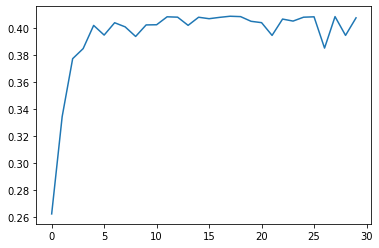

In [687]:
plt.plot(hist)
plt.show()

# Query test 2 : evaluate parameter='ndcg'

In [688]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['اجتماعی', 'سلامت', 'ورزشی', 'سیاسی'], evalParameter='ndcg')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.46189588778692425


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.5201425832002751


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5518905699932822


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5445461417611694


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5560868219069106


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5525888966044593


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.554169601213487


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.5623853682912588


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5597980192351429


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5457903600448513


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5650697000882718


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5568172689541541


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5645374740008045


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5666642641352377


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5459326328178401


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5550963616099778


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.5652685961735244


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.54850144925807


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.5559479997359859


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5666642641352377


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5583054917099992


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5485560461554996


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.555792499074359


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5553881393705367


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5649162454885983


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5659127862010749


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5637968821306434


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.564959699409821


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.5652379180567865


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.5606331445446395


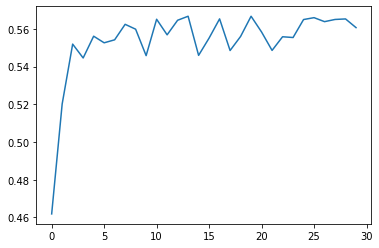

In [689]:
plt.plot(hist)
plt.show()

# Query Test 3 : evaluate parameter='ndcg'

In [690]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['اقتصادی', 'عمومی', 'ورزشی', 'سیاسی'], evalParameter='ndcg')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.28127325987990903


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.339145302379179


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.3815456586007338


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4154080320629695


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.43039219073327545


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.4233305132343894


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4245847758964598


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.43504128541896364


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.43467433821118406


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4368970719315272


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4301011556530796


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4320754519551795


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4325264116403409


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.4372156312409939


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.4321356125344839


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.43504047384520766


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4304644079849132


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.43172475467251314


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.43517081569887267


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.43001790461046596


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4355580374841431


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4246066800475579


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.42716758499902674


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.429145858348875


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.42343534574245756


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.4372328193543003


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.43517081569887267


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.4370287459780447


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.43736449340081784


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.42493788590395604


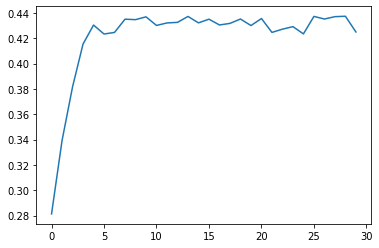

In [691]:
plt.plot(hist)
plt.show()

# Query Test 4 : evaluate parameter='ndcg'

In [693]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['اقتصادی', 'عمومی', 'ورزشی', 'اجتماعی'], evalParameter='ndcg')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5140872510550016


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elast

0.5460999970137035


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.5854012416105132


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elast

0.6296899514503013


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6485208696494075


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6584615539373078


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6583330862987093


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6536918050190302


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.643231313104715


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6521000857422182


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6500728990416275


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6492943441757794


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6571315347940645


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6575929131756758


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6508417486176403


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6508087058679075


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6501847343790522


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.658518004143035


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6517597292184427


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6583010719245652


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6551844172360757


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6587821982093442


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elast

0.6526613134220105


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6506230288288992


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.6528062757213576


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6504543830442256


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6583934648831343


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6597299306204798


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.6583221586270283


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.6589483765081465


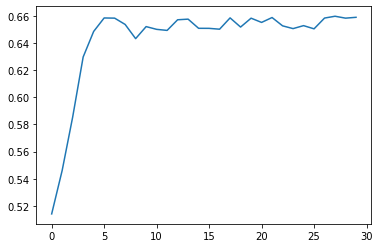

In [694]:
plt.plot(hist)
plt.show()

# Query Test 1 : evaluate parameter='map'

In [745]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['سیاسی', 'سلامت', 'ورزشی', 'علمی'], evalParameter='map')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.09150270061728395


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.1052634479717813


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.035s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.10989445546737214


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.11188960537918871


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.10989445546737214


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.003s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elast

0.10811287477954146


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.004s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elast

0.10811287477954146


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.11010802469135804


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.1121031746031746


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.10811287477954146


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.1121031746031746


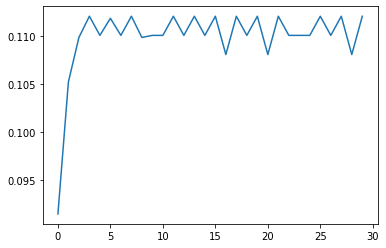

In [746]:
plt.plot(hist)
plt.show()

# Query Test 2 : evaluate parameter='map'

In [751]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['اجتماعی', 'سلامت', 'ورزشی', 'اقتصادی'], evalParameter='map')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.34930621816656404


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elast

0.35209724519846797


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elast

0.35296056225144157


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elast

0.35311222831811134


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elast

0.3533401003299772


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elast

0.3535027595064925


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.025s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elast

0.35331811411028624


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.35343754667114197


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.3535027595064925


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.026s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elast

0.3535027595064925


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.025s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.032s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elast

0.3533833269456369


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.025s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.35361119895750276


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.3529977401360861


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.35361119895750276


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.35361119895750276


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elast

0.35361119895750276


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elast

0.3535027595064925


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elast

0.3535027595064925


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elast

0.35343754667114197


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elast

0.35344853978098745


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.35355697923199764


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.35344853978098745


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.3535027595064925


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elast

0.3535027595064925


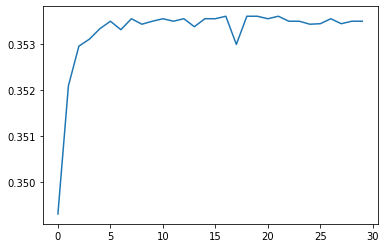

In [752]:
plt.plot(hist)
plt.show()

# Query Test 3 : evaluate parameter='map'

In [736]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['اقتصادی', 'عمومی', 'ورزشی', 'سیاسی'], evalParameter='map')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elast

0.12628735750833275


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.13787692491037865


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.14563971889823282


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.1479318807363183


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.1479318807363183


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.1479318807363183


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.1479318807363183


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14717530706307796


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14715189780979257


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14715189780979257


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.1479318807363183


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14715189780979257


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14717530706307796


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.006s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.1479318807363183


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.005s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.1471678267902898


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.14754985376330407


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.1479318807363183


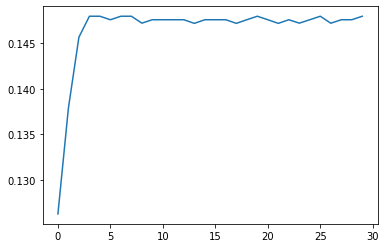

In [737]:
plt.plot(hist)
plt.show()

# Query Test 4 : evaluate parameter='map'

In [730]:
generation = init()
hist = []
for i in range(30):
    generation, maxEval = nextGeneration(generation, query = ['اقتصادی', 'عمومی', 'ورزشی', 'اجتماعی'], evalParameter='map')
    hist.append(maxEval)

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elast

0.3437542716925368


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.031s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.025s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elast

0.3566322492722464


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elast

0.36358497032111387


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elast

0.3689792503740885


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.028s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.026s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.026s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.030s]
INFO:elast

0.37376834655103885


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.027s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elast

0.37542333205875716


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.026s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.035s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elast

0.3760159731219168


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.023s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.020s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elast

0.3750003882779811


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.025s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.022s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.021s]
INFO:elast

0.376163857972443


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elast

0.37290127360255837


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.024s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.019s]
INFO:elast

0.3768623714639239


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.3776679511082591


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.3788891510514374


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.3778631305201759


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.3785802276872312


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elast

0.3764865061537367


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elast

0.37869397163952057


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

0.37683710998891445


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.3771107356691268


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.37751252668499813


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.018s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.014s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elast

0.37869397163952057


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elast

0.37751252668499813


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.3776679511082591


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.017s]
INFO:elast

0.3778631305201759


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elast

0.37774938656788654


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elast

0.3764865061537367


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.007s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.015s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.016s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elast

0.3769276540174898


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elast

0.3764865061537367


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elast

0.37712283342940656


INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.009s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.013s]
INFO:elast

0.3783736160832767


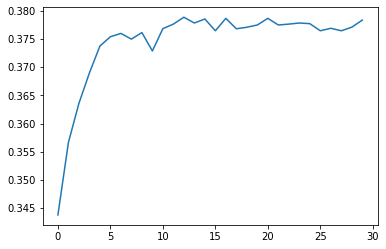

In [731]:
plt.plot(hist)
plt.show()

# Final Score Example

In [732]:
finalWeights, _ = selection(generation, selectSize=1, query=['اقتصادی', 'عمومی', 'ورزشی', 'اجتماعی'])
finalWeights = finalWeights[0]
finalWeights

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.008s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.010s]
INFO:elast

array([1., 2., 8., 8.])

In [733]:
q = createQuery(part1 = 'اجتماعی', 
                part2 = 'ورزشی', 
                part3 = 'عمومی', 
                part4 = 'اقتصادی',
                w1    = finalWeights[3], 
                w2    = finalWeights[2], 
                w3    = finalWeights[1], 
                w4    = finalWeights[0])

In [734]:
bodySearchRes = search(q, 100, 'Body')
catSearchRes = search(q, 100, 'Cat_fa')
    
bodyResTemp = {}
for i in range(len(bodySearchRes)):
    bodyResTemp[str(bodySearchRes[i])] = i     
catResTemp = {}
for i in range(len(catSearchRes)):
    catResTemp[str(catSearchRes[i])] = i
        
bodyResDic = {
    'q1' : bodyResTemp
}
catResDic = {
    'q1' : catResTemp
}
eval = evaluate(bodyResDic, catResDic)
eval

INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.011s]
INFO:elasticsearch:POST http://localhost:9200/examind/_search?size=100 [status:200 request:0.012s]


{'q1': {'map': 0.3788891510514374, 'ndcg': 0.5160895124218349}}